## CPOL animated gif generator

Based on code created by Scott Collis, Johnathan Helmus, Zachary Sherman, and myself

In [2]:
import pyart
import gzip
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import rcParams
from scipy import ndimage
import shutil, os
from datetime import timedelta, datetime
import numpy as np
import tempfile
import glob
import re
from copy import deepcopy
from IPython.display import Image, display
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119 


In [3]:
# Input the range of dates and time wanted for the collection of images
start_year = 2006
start_day = 19
start_month = 1
start_hour = 23
start_minute = 00
start_second = 0

end_year = 2006
end_month = 1
end_day = 20
end_hour = 1
end_minute = 10
end_second = 00

data_path = '/home/rjackson/multidop_grids/'

This looks for all of the available timeperiods in the data_path directory and pulls out
the file names that match the given time periods above.

In [4]:
# get_radar_times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_dda_times(start_year, start_month, start_day,
                  start_hour, start_minute, end_year,
                  end_month, end_day, end_hour, 
                  end_minute, minute_interval=5):

    start_time = datetime(start_year,
                      start_month,
                      start_day,
                      start_hour,
                      start_minute,
                      )
    end_time = datetime(end_year,
                      end_month,
                      end_day,
                      end_hour,
                      end_minute,
                      )

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    

    # Find the list of files for each day
    cur_time = start_time
 
    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path +
                      'cf_compliant_grid' +
                      year_str +
                      month_str +
                      day_str +
                      '*.nc')
    
    
        print('Looking for files with format ' + format_str)
          
        data_list = glob.glob(format_str)
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-15:-3]
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[8:10]
        minute_str = date_str[10:12]
        second_str = '00'
        print(date_str)      
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            int(second_str))
        time_list.append(cur_time)
        
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
    
    
    for times in time_list_sorted: 
        
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
           
            
            
    
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_grid_from_dda(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path +
                    'cf_compliant_grid' +
                     year_str +
                     month_str +
                     day_str +
                     hour_str +
                     minute_str + '.nc')
    
    radar = pyart.io.read_grid(file_name_str)
    return radar



In [5]:
# Plot the radars from given time.

times = get_dda_times(start_year, start_month, start_day,
                      start_hour, start_minute, end_year,
                      end_month, end_day, end_hour, 
                      end_minute, minute_interval=10)
print(times)


We are about to load grid files for 2 days
Looking for files with format /home/rjackson/multidop_grids/cf_compliant_grid20060119*.nc
Looking for files with format /home/rjackson/multidop_grids/cf_compliant_grid20060120*.nc
200601192300
200601192350
200601192330
200601200000
200601200050
200601200030
[datetime.datetime(2006, 1, 19, 23, 30), datetime.datetime(2006, 1, 19, 23, 50), datetime.datetime(2006, 1, 20, 0, 0), datetime.datetime(2006, 1, 20, 0, 30), datetime.datetime(2006, 1, 20, 0, 50)]


This loads the Grid files and creates the animation

In [6]:
# Reflectivity plot callback function
def plot_horiz_reflectivity(frame_number):

    plt.clf()
    
    pyart_grid = get_grid_from_dda(times[frame_number])
    
    level = 5
    
    CPOLGridDisplay = pyart.graph.GridMapDisplay(pyart_grid)
    CPOLGridDisplay.plot_basemap(min_lat=-12.8, max_lat=-12.0,
                                 min_lon=130.6, max_lon=131.4,
                                 auto_range=False,
                                 lat_lines=[-12.8, -12.6, -12.4, -12.2, -12.0],
                                 lon_lines=[130.6,130.8, 131.0, 131.2, 131.4],
                                 resolution='i')
    CPOLGridDisplay.plot_grid('reflectivity', level, vmin=-10, vmax=70,
                              cmap=pyart.graph.cm.NWSRef)

    lons, lats = pyart_grid.get_point_longitude_latitude(level=level)
    v = pyart_grid.fields['northward_wind']['data'][level]
    u = pyart_grid.fields['eastward_wind']['data'][level]
    w = pyart_grid.fields['upward_air_velocity']['data'][level]
    Wcomp = np.amax(pyart_grid.fields['upward_air_velocity']['data'], axis=0)
     
    # Plot every second arrow
    lons = lons[0::2,0::2]
    lats = lats[0::2,0::2]
    v = v[0::2,0::2]
    u = u[0::2,0::2]
    w = w[0::2,0::2]
    q = CPOLGridDisplay.basemap.quiver(lons, lats, 
                                      u, v, 
                                      scale=600,
                                      latlon='True')
    qk = plt.quiverkey(q, 1.01, 1.01, 10, r'$10  \frac{m}{s}$',
                   fontproperties={'weight': 'bold'})
    CS = CPOLGridDisplay.basemap.contour(lons, lats,
                                         w, latlon='True',
                                         levels=[1, 4, 6, 10])
    plt.clabel(CS, inline=1, fontsize=10)
    cpol_latitude = -12.249166
    cpol_longitude = 131.04445
    berr_latitude = -12.456944
    berr_longitude = 130.925
    berr_x, berr_y = CPOLGridDisplay.basemap(berr_longitude, berr_latitude)
    plt.annotate('Berrima', xy=(berr_x, berr_y), 
                 xycoords='data', fontweight='bold',
                 fontsize=20)
    cpol_x, cpol_y = CPOLGridDisplay.basemap(cpol_longitude, cpol_latitude)
    plt.annotate('CPOL', xy=(cpol_x, cpol_y), 
                 xycoords='data', fontweight='bold',
                 fontsize=20)
    
# Rainfall rate estimate
def plot_rainfall(frame_number):

    plt.clf()
    
    pyart_grid = get_grid_from_dda(times[frame_number])
    alpha=0.0376
    beta=0.6112
    refl = pyart_grid.fields['reflectivity']['data']
    rr_data = alpha*np.ma.power(np.ma.power(10., 0.1*refl), beta)
    level = 5
    pyart_grid.add_field('rainfall_rate', {'data':rr_data}, replace_existing=True)
    
    
    CPOLGridDisplay = pyart.graph.GridMapDisplay(pyart_grid)
    CPOLGridDisplay.plot_basemap(min_lat=-12.8, max_lat=-12.0,
                                 min_lon=130.6, max_lon=131.4,
                                 auto_range=False,
                                 lat_lines=[-12.8, -12.6, -12.4, -12.2, -12.0],
                                 lon_lines=[130.6,130.8, 131.0, 131.2, 131.4],
                                 resolution='i')
    CPOLGridDisplay.plot_grid('rainfall_rate', 0, vmin=0, vmax=70,
                              cmap=pyart.graph.cm.NWSRef)

    lons, lats = pyart_grid.get_point_longitude_latitude(level=level)
    v = pyart_grid.fields['northward_wind']['data'][level]
    u = pyart_grid.fields['eastward_wind']['data'][level]
    w = pyart_grid.fields['upward_air_velocity']['data'][level]
    Wcomp = np.amax(pyart_grid.fields['upward_air_velocity']['data'], axis=0)
     
    # Plot every second arrow
    lons = lons[0::2,0::2]
    lats = lats[0::2,0::2]
    v = v[0::2,0::2]
    u = u[0::2,0::2]
    w = w[0::2,0::2]
    q = CPOLGridDisplay.basemap.quiver(lons, lats, 
                                      u, v, 
                                      scale=600,
                                      latlon='True')
    qk = plt.quiverkey(q, 1.01, 1.01, 10, r'$10  \frac{m}{s}$',
                   fontproperties={'weight': 'bold'})
    CS = CPOLGridDisplay.basemap.contour(lons, lats,
                                         w, latlon='True',
                                         levels=[1, 4, 6, 10])
    plt.clabel(CS, inline=1, fontsize=10)
    cpol_latitude = -12.249166
    cpol_longitude = 131.04445
    berr_latitude = -12.456944
    berr_longitude = 130.925
    berr_x, berr_y = CPOLGridDisplay.basemap(berr_longitude, berr_latitude)
    plt.annotate('Berrima', xy=(berr_x, berr_y), 
                 xycoords='data', fontweight='bold',
                 fontsize=20)
    cpol_x, cpol_y = CPOLGridDisplay.basemap(cpol_longitude, cpol_latitude)
    plt.annotate('CPOL', xy=(cpol_x, cpol_y), 
                 xycoords='data', fontweight='bold',
                 fontsize=20)
    
# W plot callback function
def plot_horiz_w(frame_number):
    level = 5
    plt.clf()
    
    pyart_grid = get_grid_from_dda(times[frame_number])
    
    
    CPOLGridDisplay = pyart.graph.GridMapDisplay(pyart_grid)
    CPOLGridDisplay.plot_basemap(min_lat=-12.8, max_lat=-12.0,
                                 min_lon=130.6, max_lon=131.4,
                                 auto_range=False,
                                 lat_lines=[-12.8, -12.6, -12.4, -12.2, -12.0],
                                 lon_lines=[130.6, 130.8, 131.0, 131.2, 131.4],
                                 resolution='i')
    CPOLGridDisplay.plot_grid('upward_air_velocity', level, vmin=-10, vmax=20,
                              cmap=pyart.graph.cm.NWSRef)

    lons, lats = pyart_grid.get_point_longitude_latitude(level=level)
    v = pyart_grid.fields['northward_wind']['data'][level]
    u = pyart_grid.fields['eastward_wind']['data'][level]
    # Plot every second arrow
    lons = lons[0::2,0::2]
    lats = lats[0::2,0::2]
    v = v[0::2,0::2]
    u = u[0::2,0::2]
    w = w[0::2,0::2]
    q = CPOLGridDisplay.basemap.quiver(lons, lats, 
                                       u, v, 
                                       scale=600,
                                       latlon='True')
    qk = plt.quiverkey(q, 1.01, 1.01, 10, r'$10  \frac{m}{s}$',
                       fontproperties={'weight': 'bold'})
    cpol_latitude = -12.249166
    cpol_longitude = 131.04445
    berr_latitude = -12.456944
    berr_longitude = 130.925
    berr_x, berr_y = CPOLGridDisplay.basemap(berr_longitude, berr_latitude)
    plt.annotate('Berrima', xy=(berr_x, berr_y), 
                 xycoords='data', fontweight='bold',
                 fontsize=20)
    cpol_x, cpol_y = CPOLGridDisplay.basemap(cpol_longitude, cpol_latitude)
    plt.annotate('CPOL', xy=(cpol_x, cpol_y), 
                 xycoords='data', fontweight='bold',
                 fontsize=20)

# Plot horizontal cross section
def plot_vert_cross_section(frame_number):
    plt.clf()
    pyart_grid = get_grid_from_dda(times[frame_number])
    
    CPOLGridDisplay = pyart.graph.GridMapDisplay(pyart_grid)
    CPOLGridDisplay.plot_latitudinal_level('reflectivity', 43,
                                           cmap=pyart.graph.cm.NWSRef,
                                           vmin=-20, vmax=70)                           

    X,Y = np.meshgrid(pyart_grid.x['data']/1e3, pyart_grid.z['data']/1e3)
    v = pyart_grid.fields['upward_air_velocity']['data'][:,43,:]
    u = pyart_grid.fields['eastward_wind']['data'][:,43,:]
    # Plot every second arrow
    X = X[0::2,0::2]
    Y = Y[0::2,0::2]
    v = v[0::2,0::2]
    u = u[0::2,0::2]
    plt.quiver(X, Y, u, v, scale=400)
    CS = plt.contour(X,Y,v,levels=[1,4,6,10])
    plt.clabel(CS, inline=1, fontsize=10)
    plt.xlim([-50, 50])
    # Plot the animation.
    
# W plot callback function
def plot_horiz_w(frame_number):
    level = 5
    plt.clf()
    
    pyart_grid = get_grid_from_dda(times[frame_number])
    
    CPOLGridDisplay = pyart.graph.GridMapDisplay(pyart_grid)
    CPOLGridDisplay.plot_basemap(min_lat=-12.8, max_lat=-12.0,
                                 min_lon=130.6, max_lon=131.4,
                                 auto_range=False,
                                 lat_lines=[-12.8, -12.6, -12.4, -12.2, -12.0],
                                 lon_lines=[130.6, 130.8, 131.0, 131.2, 131.4],
                                 resolution='i')
    CPOLGridDisplay.plot_grid('upward_air_velocity', level, vmin=-10, vmax=20,
                              cmap=pyart.graph.cm.NWSRef)

    lons, lats = pyart_grid.get_point_longitude_latitude(level=level)
    v = pyart_grid.fields['northward_wind']['data'][level]
    u = pyart_grid.fields['eastward_wind']['data'][level]
    # Plot every second arrow
    lons = lons[0::2,0::2]
    lats = lats[0::2,0::2]
    v = v[0::2,0::2]
    u = u[0::2,0::2]
    q = CPOLGridDisplay.basemap.quiver(lons, lats, 
                                       u, v, 
                                       scale=600,
                                       latlon='True')
    qk = plt.quiverkey(q, 1.01, 1.01, 10, r'$10  \frac{m}{s}$',
                       fontproperties={'weight': 'bold'})
    cpol_latitude = -12.249166
    cpol_longitude = 131.04445
    berr_latitude = -12.456944
    berr_longitude = 130.925
    berr_x, berr_y = CPOLGridDisplay.basemap(berr_longitude, berr_latitude)
    plt.annotate('Berrima', xy=(berr_x, berr_y), 
                 xycoords='data', fontweight='bold',
                 fontsize=20)
    cpol_x, cpol_y = CPOLGridDisplay.basemap(cpol_longitude, cpol_latitude)
    plt.annotate('CPOL', xy=(cpol_x, cpol_y), 
                 xycoords='data', fontweight='bold',
                 fontsize=20)
    

In [ ]:
print(times)
figure = plt.figure(figsize=(10, 8))
AnimatedGIF = animation.FuncAnimation(figure, plot_horiz_reflectivity,
                                      frames=len(times))
AnimatedGIF.save("/home/rjackson/pyart_test/TWPICE_animation_reflectivity.gif",
                 writer='imagemagick', fps=3)

[datetime.datetime(2006, 1, 19, 23, 30), datetime.datetime(2006, 1, 19, 23, 50), datetime.datetime(2006, 1, 20, 0, 0), datetime.datetime(2006, 1, 20, 0, 30), datetime.datetime(2006, 1, 20, 0, 50)]


In [ ]:
print(times)
figure = plt.figure(figsize=(10, 8))
AnimatedGIF = animation.FuncAnimation(figure, plot_horiz_w,
                                      frames=len(times))
AnimatedGIF.save("/home/rjackson/pyart_test/TWPICE_animation_w.gif",
                 writer='imagemagick', fps=3)

[datetime.datetime(2006, 1, 19, 23, 30), datetime.datetime(2006, 1, 19, 23, 50), datetime.datetime(2006, 1, 20, 0, 0), datetime.datetime(2006, 1, 20, 0, 30), datetime.datetime(2006, 1, 20, 0, 50)]


[datetime.datetime(2006, 1, 19, 23, 30), datetime.datetime(2006, 1, 19, 23, 50), datetime.datetime(2006, 1, 20, 0, 0), datetime.datetime(2006, 1, 20, 0, 30), datetime.datetime(2006, 1, 20, 0, 50)]


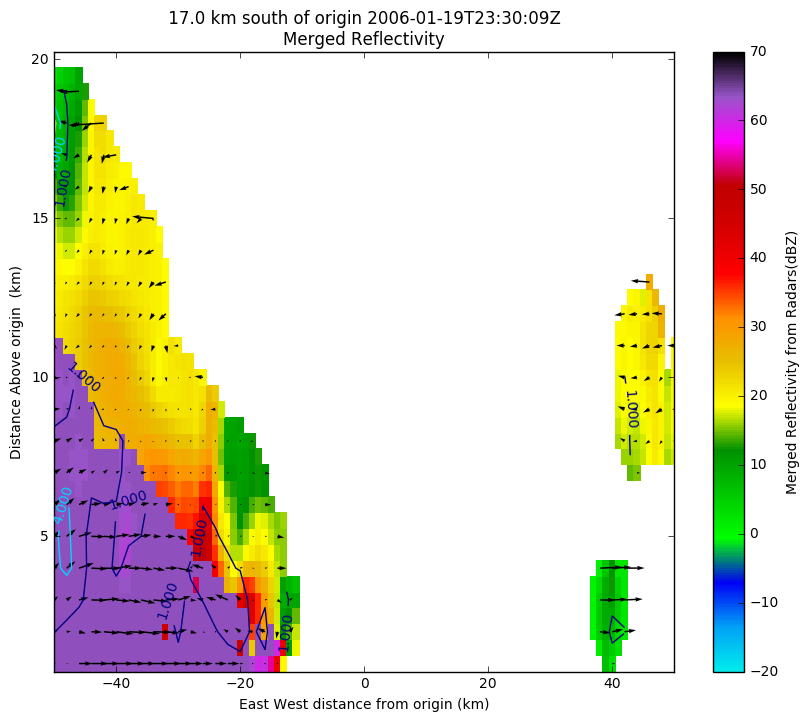

In [17]:
print(times)
figure = plt.figure(figsize=(10, 8))
AnimatedGIF = animation.FuncAnimation(figure, plot_vert_cross_section,
                                      frames=len(times))
AnimatedGIF.save("/home/rjackson/pyart_test/TWPICE_animation_cross_section.gif",
                 writer='imagemagick', fps=3)

In [1]:
print(times)
figure = plt.figure(figsize=(10, 8))
AnimatedGIF = animation.FuncAnimation(figure, plot_rainfall,
                                      frames=len(times))
AnimatedGIF.save("/home/rjackson/pyart_test/TWPICE_animation_rainfall.gif",
                 writer='imagemagick', fps=3)

NameError: name 'times' is not defined

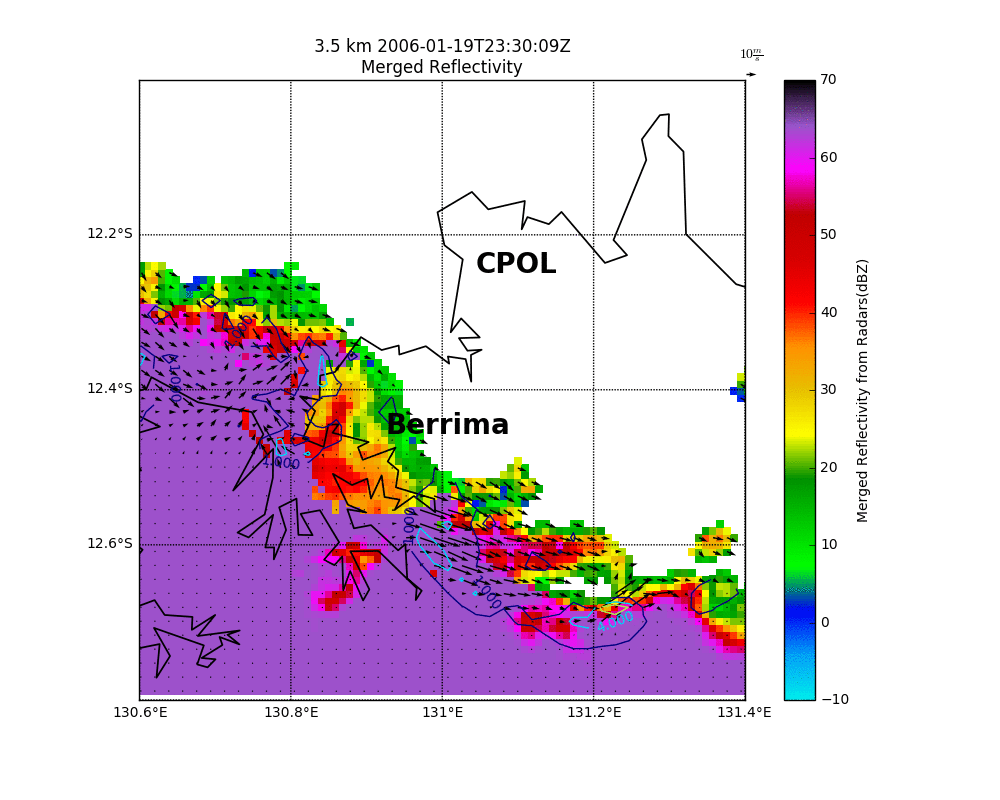

In [7]:
with open('/home/rjackson/pyart_test/TWPICE_animation_reflectivity.gif','rb') as f:
    display(Image(f.read()), format='gif')

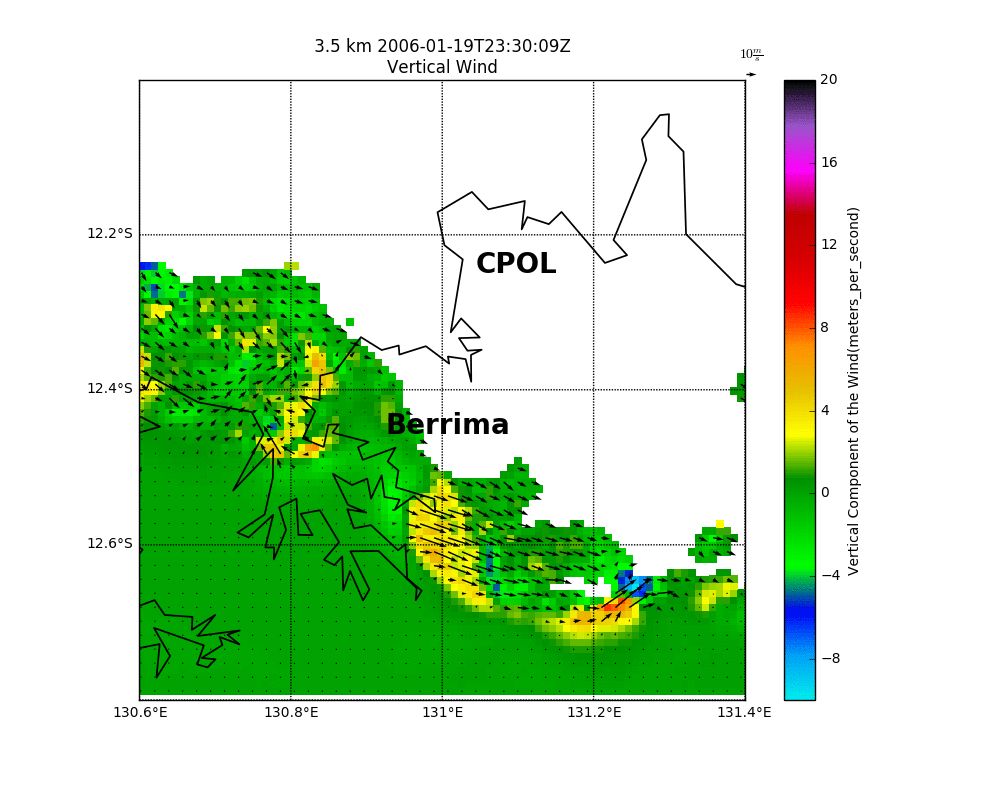

In [8]:
with open('/home/rjackson/pyart_test/TWPICE_animation_w.gif','rb') as f:
    display(Image(f.read()), format='gif')

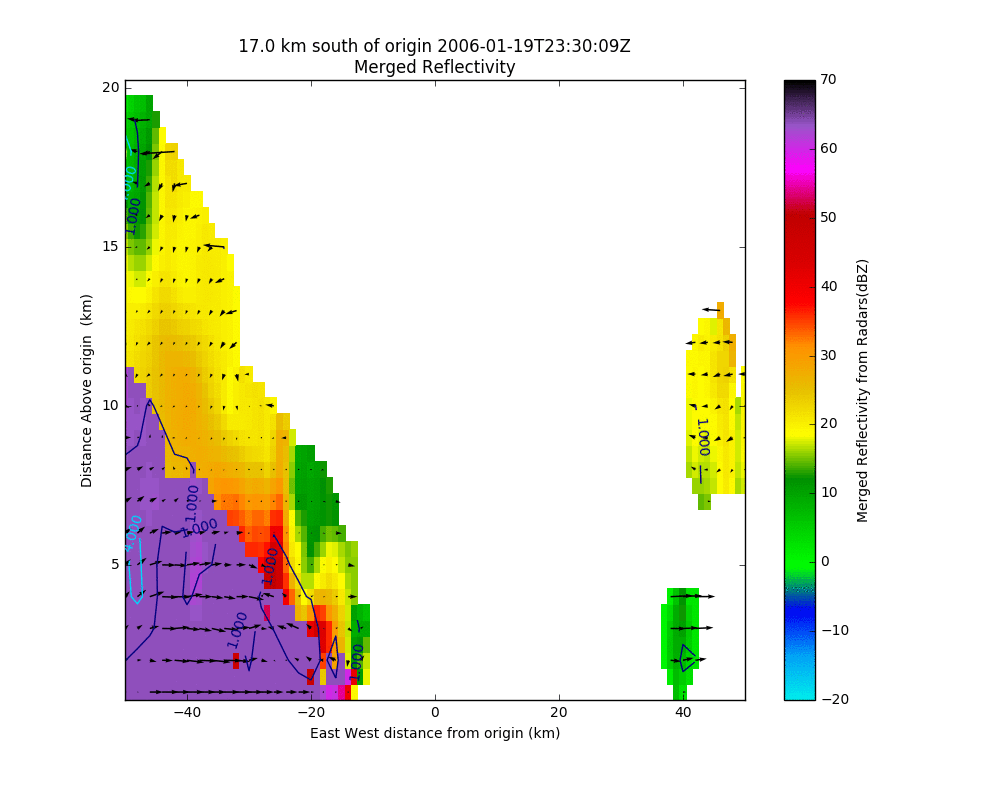

In [18]:
with open('/home/rjackson/pyart_test/TWPICE_animation_cross_section.gif','rb') as f:
    display(Image(f.read()), format='gif')

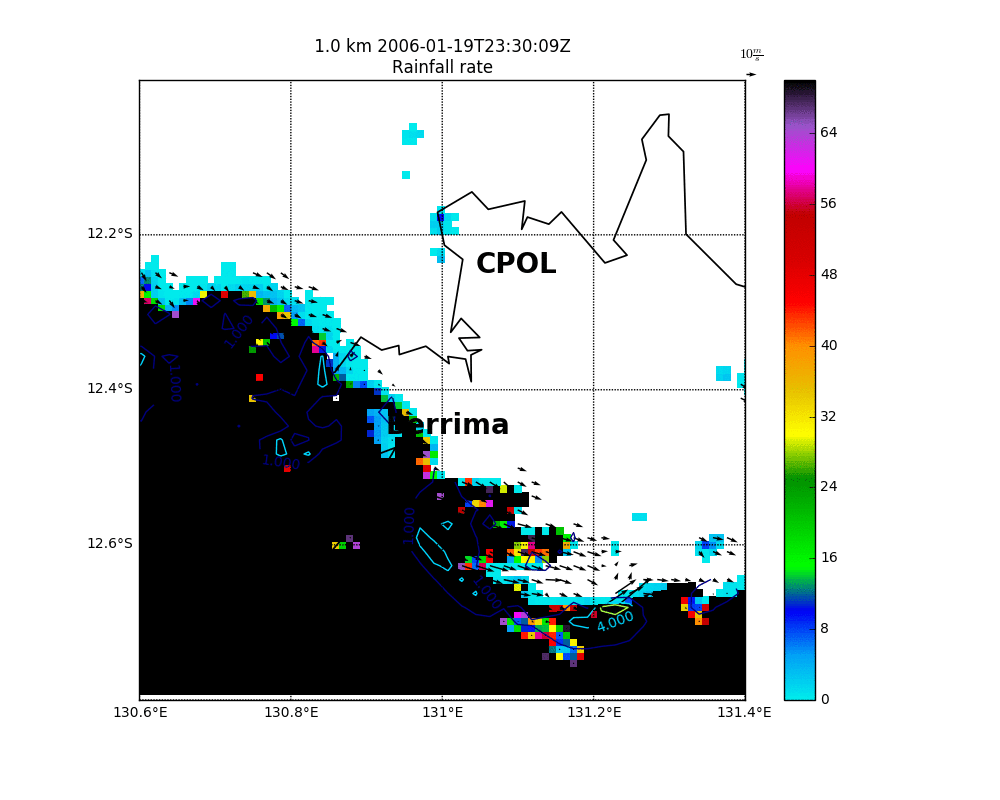

In [7]:
with open('/home/rjackson/pyart_test/TWPICE_animation_rainfall.gif','rb') as f:
    display(Image(f.read()), format='gif')